In [1]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")

In [4]:
# !pip install kaggle

# from google.colab import files
# # Upload the Kaggle API key (kaggle.json)
# files.upload()

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using the Kaggle API
!kaggle competitions download -c plant-pathology-2020-fgvc7

# Unzip the dataset
!unzip plant-pathology-2020-fgvc7.zip

100% 777M/779M [00:06<00:00, 156MB/s]
100% 779M/779M [00:06<00:00, 134MB/s]
Archive:  plant-pathology-2020-fgvc7.zip
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflati

In [5]:
submission = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [7]:
test.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [8]:
submission.head()


image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25

In [9]:
train_img=[]
train_label=[]
path='images'
for im in tqdm(train['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    img=img.astype('float32')
    train_img.append(img)


100%|██████████| 1821/1821 [00:55<00:00, 32.81it/s]


In [10]:
test_img=[]
path='images'
for im in tqdm(test['image_id']):
    im=im+".jpg"
    final_path=os.path.join(path,im)
    img=cv2.imread(final_path)
    img=cv2.resize(img,(224,224))
    img=img.astype(('float32'))
    test_img.append(img)

100%|██████████| 1821/1821 [00:55<00:00, 32.89it/s]


#Visualizations

In [11]:
fig = px.imshow(cv2.resize(train_img[0], (205, 136)))
fig.show()

In [12]:
def visualize_leaves(train_img, train, cond, cond_cols, is_cond=True):
    if not is_cond:
        cols, rows = 3, min([3, len(train_img)//3])
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
        for col in range(cols):
            for row in range(rows):
                ax[row, col].imshow(cv2.cvtColor(train_img[-row*3-col-1], cv2.COLOR_BGR2RGB).astype('uint8'))  # Convert BGR to RGB
        plt.show()
        return None

    cond_0 = "healthy == {}".format(cond[0])
    cond_1 = "scab == {}".format(cond[1])
    cond_2 = "rust == {}".format(cond[2])
    cond_3 = "multiple_diseases == {}".format(cond[3])

    cond_list = []
    for col in cond_cols:
        if col == "healthy":
            cond_list.append(cond_0)
        if col == "scab":
            cond_list.append(cond_1)
        if col == "rust":
            cond_list.append(cond_2)
        if col == "multiple_diseases":
            cond_list.append(cond_3)

    data = train[:100]
    for cond in cond_list:
        data = data.query(cond)

    image_indices = list(data.index)
    cols, rows = 3, min([3, len(image_indices)//3])

    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(30, rows*20/3))
    for col in range(cols):
        for row in range(rows):
            index = image_indices[row*3+col]
            ax[row, col].imshow(cv2.cvtColor(train_img[index], cv2.COLOR_BGR2RGB).astype('uint8'))  # Convert BGR to RGB
    plt.show()


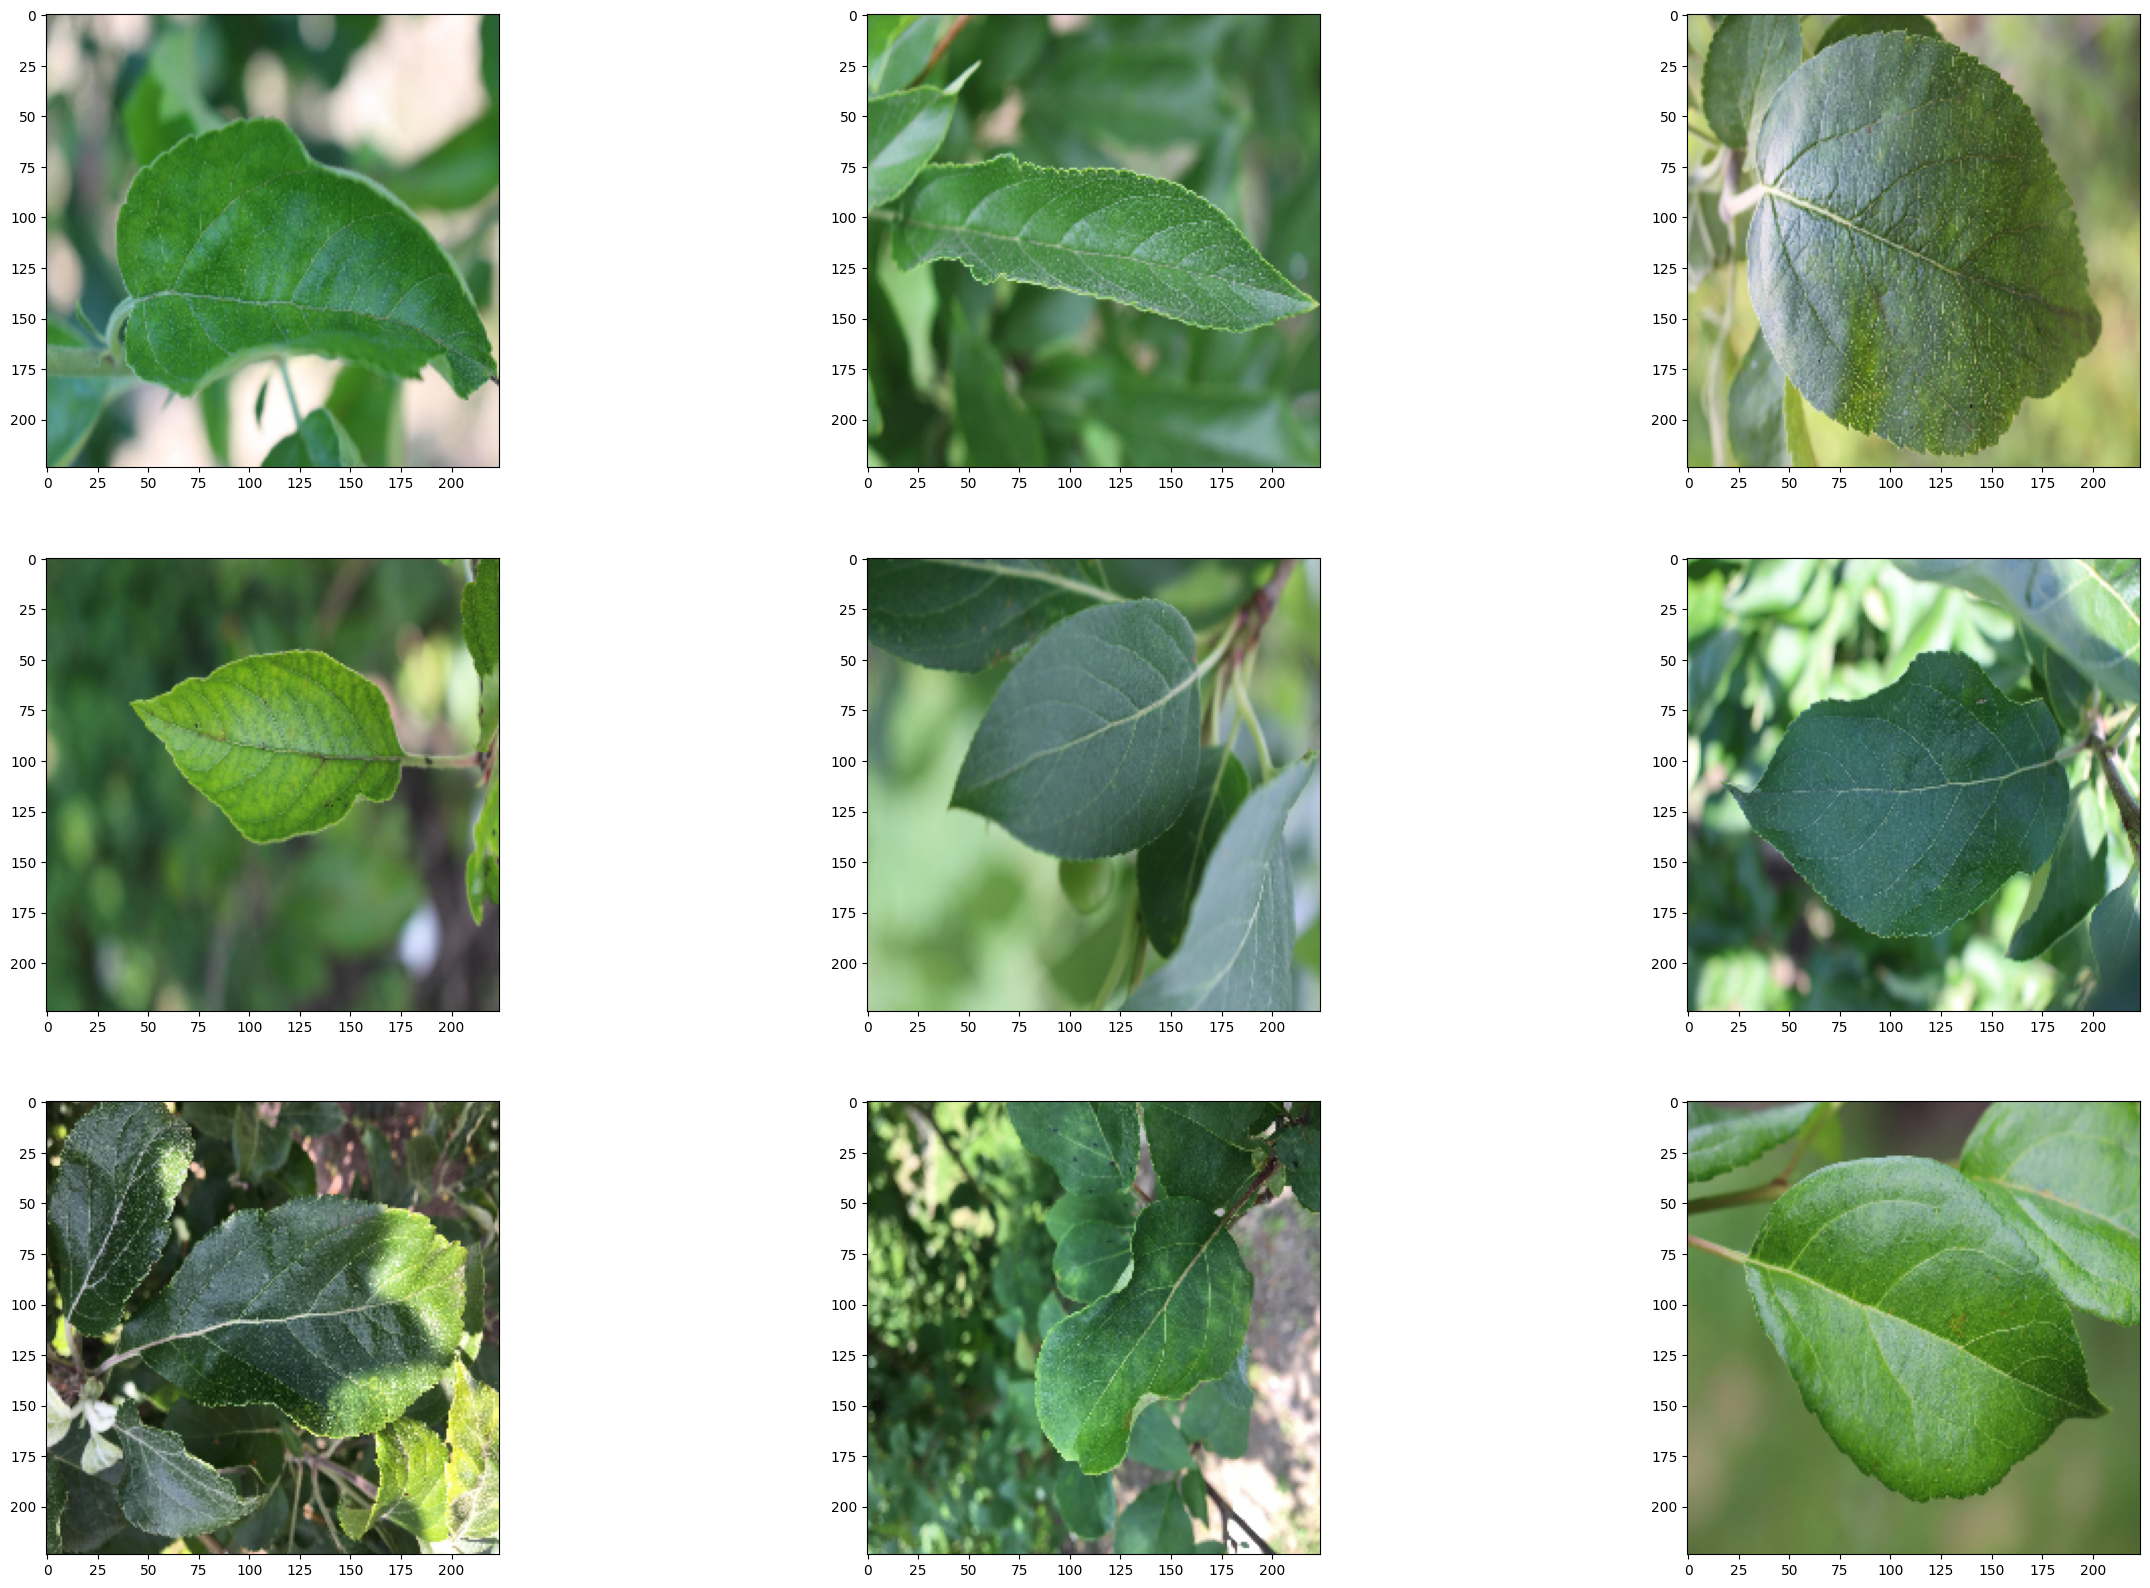

In [13]:
visualize_leaves(train_img, train, cond=[1, 0, 0, 0], cond_cols=["healthy"])

In [14]:
#pie chart
fig = go.Figure([go.Pie(labels=train.columns[1:],
           values=train.iloc[:, 1:].sum().values)])
fig.update_layout(title_text="Pie chart of targets", template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In [15]:
#Healthy Distribution
train["Healthy"] = train["healthy"].apply(bool).apply(str)
fig = px.histogram(train, x="Healthy", title="Healthy distribution", color="Healthy",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[0],
                "False": px.colors.qualitative.Plotly[1]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

In [16]:
#Scab Distribution
train["Scab"] = train["scab"].apply(bool).apply(str)
fig = px.histogram(train, x="Scab", color="Scab", title="Scab distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

In [17]:
#Rust Distribution
train["Rust"] = train["rust"].apply(bool).apply(str)
fig = px.histogram(train, x="Rust", color="Rust", title="Rust distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

In [18]:
#Multiple Diseases Distribution
train["Multiple diseases"] = train["multiple_diseases"].apply(bool).apply(str)
fig = px.histogram(train, x="Multiple diseases", color="Multiple diseases", title="Multiple diseases distribution",\
            color_discrete_map={
                "True": px.colors.qualitative.Plotly[1],
                "False": px.colors.qualitative.Plotly[0]})
fig.update_layout(template="simple_white")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig

#Image Processing

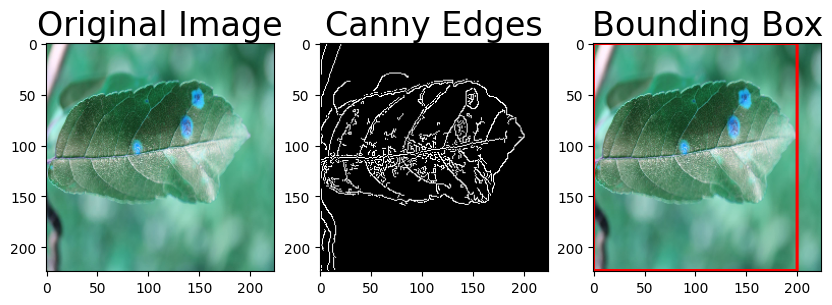

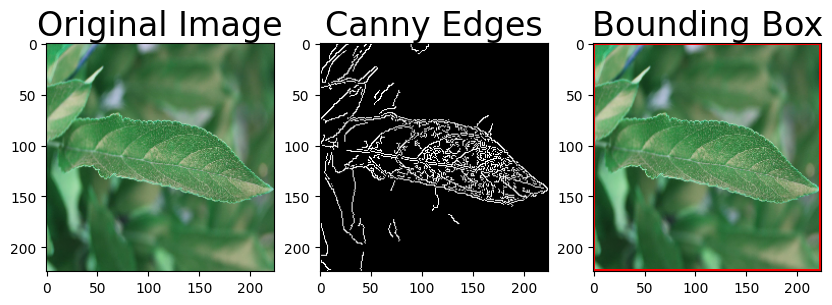

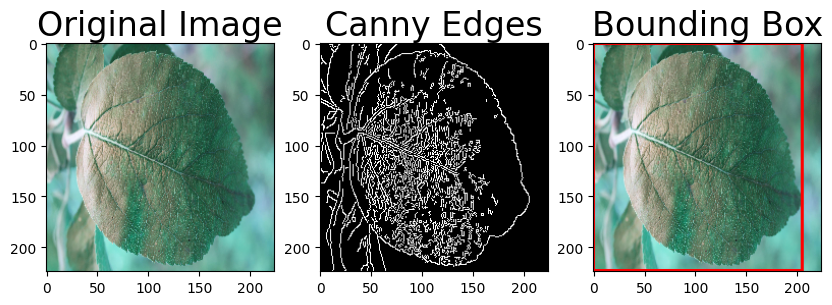

In [19]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = np.argwhere(edges > 0)

    if edge_coors.size == 0:
        # No edges found in the image, just display it.
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Original Image', fontsize=24)
        ax[1].imshow(edges, cmap='gray')
        ax[1].set_title('Canny Edges', fontsize=24)
        plt.show()
        return

    row_min, col_min = edge_coors.min(axis=0)
    row_max, col_max = edge_coors.max(axis=0)

    new_img = img[row_min:row_max, col_min:col_max]

    # Draw bounding box on the copied image
    cv2.rectangle(emb_img, (col_min, row_min), (col_max, row_max), (255, 0, 0), thickness=2)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

# Assuming train_img is a list of images
edge_and_cut(np.uint8(train_img[3]))
edge_and_cut(np.uint8(train_img[4]))
edge_and_cut(np.uint8(train_img[5]))


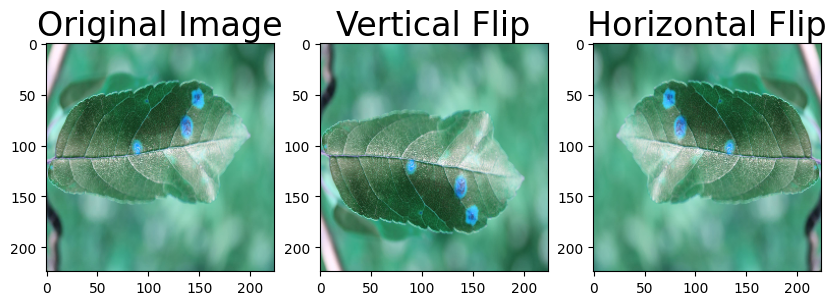

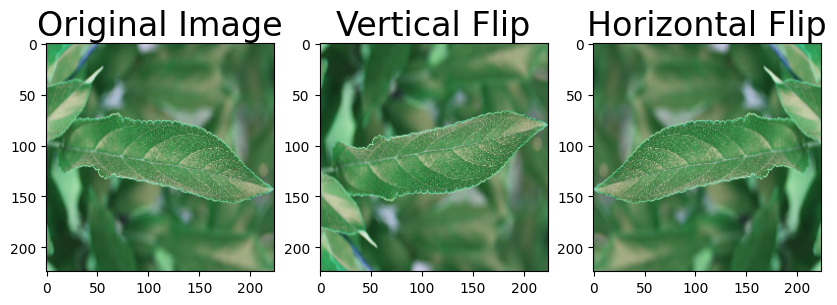

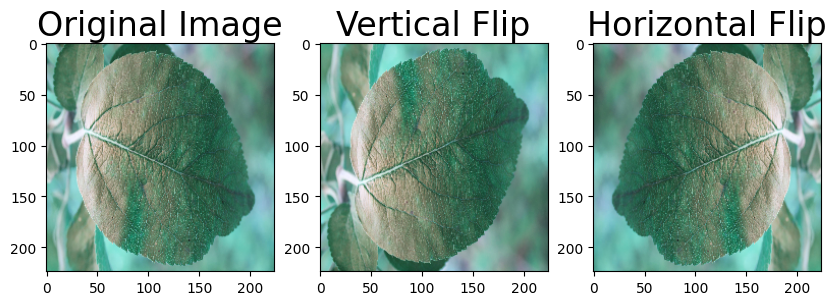

In [20]:
#Flipping the image
def invert(img):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(cv2.flip(img, 0))
    ax[1].set_title('Vertical Flip', fontsize=24)
    ax[2].imshow(cv2.flip(img, 1))
    ax[2].set_title('Horizontal Flip', fontsize=24)
    plt.show()

invert(np.uint8(train_img[3]))
invert(np.uint8(train_img[4]))
invert(np.uint8(train_img[5]))


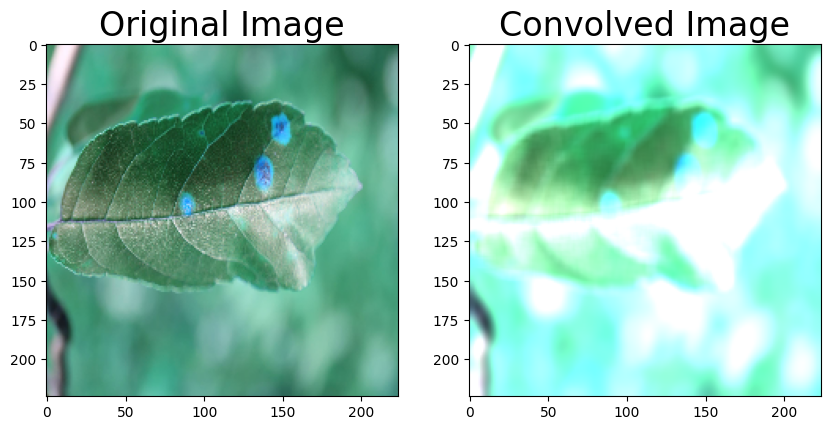

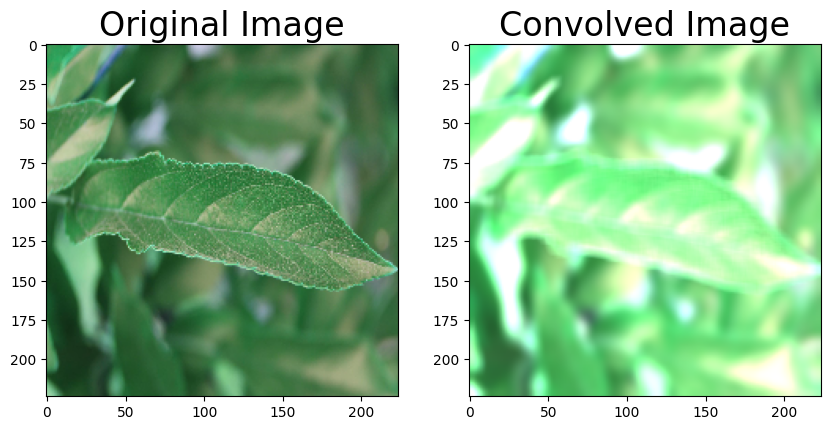

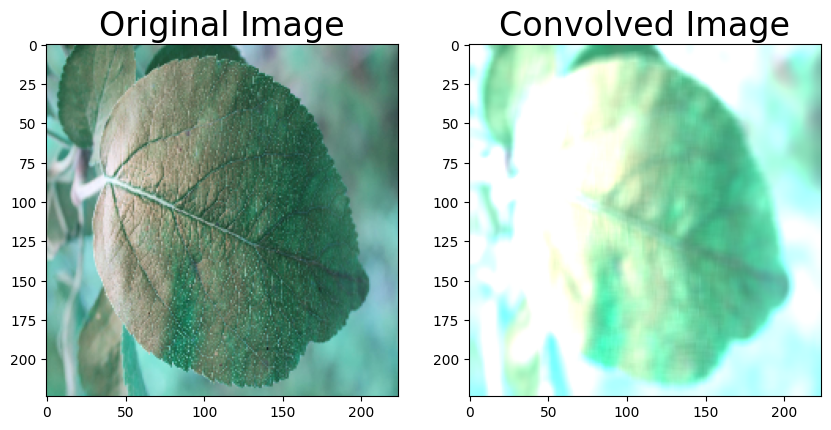

In [21]:
#Convolution
def conv(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
    kernel = np.ones((7, 7), np.float32)/25
    conv = cv2.filter2D(img, -1, kernel)
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(conv)
    ax[1].set_title('Convolved Image', fontsize=24)
    plt.show()

conv(np.uint8(train_img[3]))
conv(np.uint8(train_img[4]))
conv(np.uint8(train_img[5]))

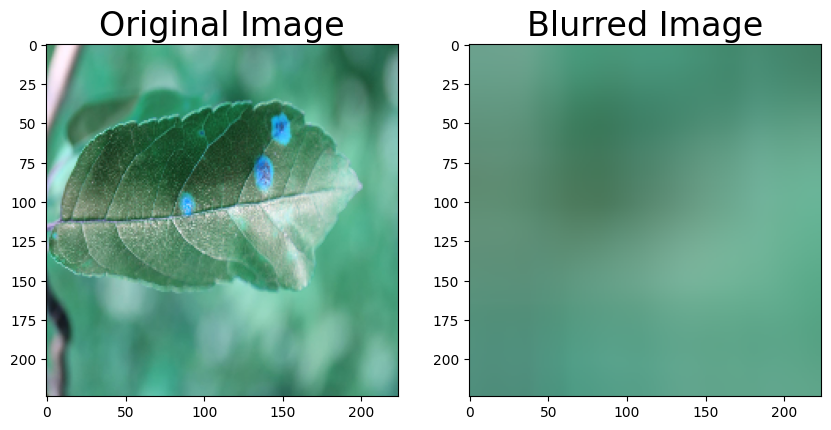

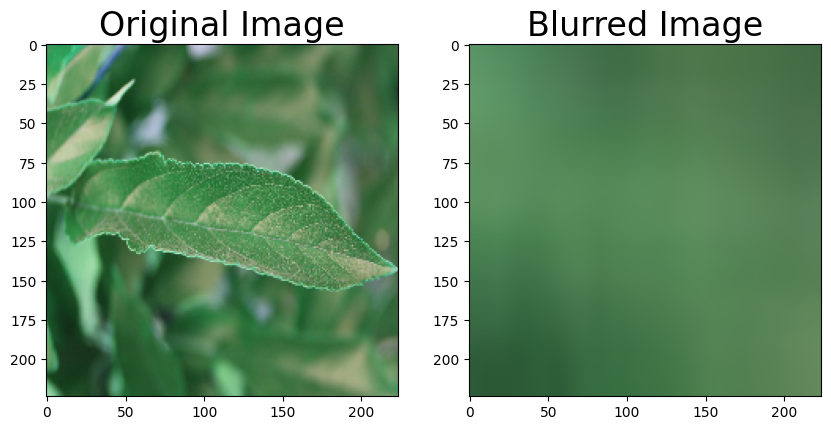

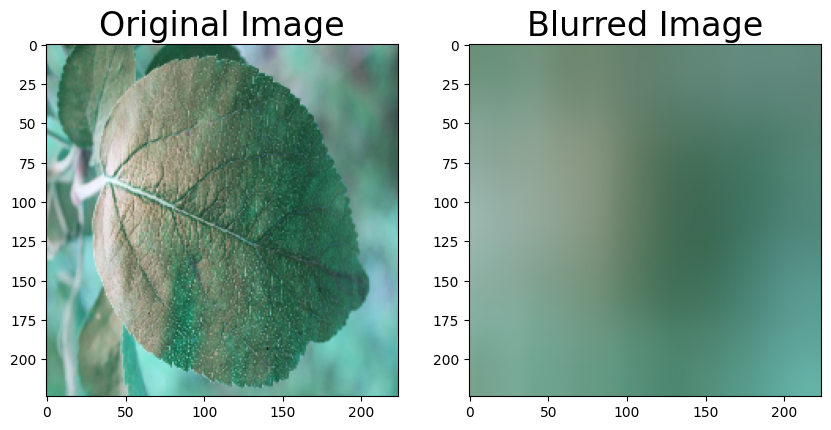

In [22]:
#Bluring the image
def blur(img):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(cv2.blur(img, (100, 100)))
    ax[1].set_title('Blurred Image', fontsize=24)
    plt.show()

blur(np.uint8(train_img[3]))
blur(np.uint8(train_img[4]))
blur(np.uint8(train_img[5]))

In [23]:
train_label=train.loc[:,'healthy':'scab']

In [24]:
train_img=np.array(train_img)
test_img=np.array(test_img)
train_label=np.array(train_label)

In [25]:
print(train_img.shape)
print(test_img.shape)
print(train_label.shape)

(1821, 224, 224, 3)
(1821, 224, 224, 3)
(1821, 4)


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=False)

datagen.fit(train_img)

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.callbacks import ReduceLROnPlateau

In [28]:
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3), pooling='avg')

model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(4,activation='softmax'))

from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

for layer in base_model.layers[:-10]:
    layer.trainable = True

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

model.compile( optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(datagen.flow(train_img, train_label, batch_size=32),
                    epochs=15,callbacks=callbacks)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/15
57/57 [==============================] - 53s 520ms/step - loss: 5.6945 - accuracy: 0.3509 - lr: 0.0010
Epoch 2/15
57/57 [==============================] - 21s 357ms/step - loss: 1.2716 - accuracy: 0.3256 - lr: 0.0010
Epoch 3/15
57/57 [==============================] - 21s 359ms/step - loss: 1.2566 - accuracy: 0.3355 - lr: 0.0010
Epoch 4/15
57/57 [==============================] - 21s 363ms/step - loss: 1.2475 - accuracy: 0.3460 - lr: 0.0010
Epoch 5/15
57/57 [==============================] - 21s 364ms/step - loss: 1.2450 - accuracy: 0.3405 - lr: 0.0010
Epoch 6/15
57/57 [==============================] - 21s 365ms/step - loss: 1.2425 - accuracy: 0.3416 - lr: 0.0010
Epoch 7/15
57/57 [==============================] - 21s 368ms/step - loss: 1.2774 - accuracy: 0.3608 - lr: 0.0010
Epoch 8/15
57/57 [==============================] - 21s 370ms/step - loss: 1.0411 - accuracy: 0.5387 - lr: 0.0010
Epoch 9/15
57/57 [=====

In [29]:
y_pred=model.predict(test_img)
print(y_pred)

57/57 [==============================] - 7s 115ms/step
[[4.48781662e-07 4.93475422e-02 9.50651944e-01 4.76374176e-08]
 [8.89579358e-04 9.20565501e-02 9.06108379e-01 9.45480424e-04]
 [5.52770570e-02 1.44906780e-02 9.39510937e-04 9.29292679e-01]
 ...
 [1.88684196e-03 1.80773199e-01 8.13943923e-01 3.39604984e-03]
 [9.71480548e-01 5.85358031e-03 3.53855849e-03 1.91273093e-02]
 [2.66167015e-01 2.95205712e-01 3.27862531e-01 1.10764675e-01]]


In [30]:
submission.loc[:,'healthy':'scab']=y_pred

In [31]:
submission.head()

image_id       healthy  multiple_diseases      rust          scab
0   Test_0  4.487817e-07           0.049348  0.950652  4.763742e-08
1   Test_1  8.895794e-04           0.092057  0.906108  9.454804e-04
2   Test_2  5.527706e-02           0.014491  0.000940  9.292927e-01
3   Test_3  9.871023e-01           0.002742  0.002173  7.982877e-03
4   Test_4  1.113776e-07           0.050856  0.949144  1.129593e-08

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['healthy'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['multiple_diseases'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['rust'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['scab'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['healthy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['multiple_diseases'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['rust'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['scab'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_8, *['image_id'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_9, *[[['healthy', 'multiple_diseases'], ['multiple_diseases', 'rust'], ['rust', 'scab']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_10, *['healthy', 'image_id'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_11, *['multiple_diseases', 'image_id'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_12, *['rust', 'image_id'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_13, *['scab', 'image_id'], **{'inner': 'stick'})
chart

In [34]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(test_img, y_pred, verbose=1)

print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")


57/57 [==============================] - 7s 112ms/step - loss: 0.4723 - accuracy: 1.0000
Validation Accuracy: 100.00%


In [32]:
model.save("plant_pathology_model.h5")